# Models – Predicting Student Performance Using Machine Learning

This notebook focuses on implementing machine learning regression models to predict student academic performance based on various features such as moodle or caronte activity, past grades, participation, and other contextual factors. By anticipating students' future marks, this system aims to identify at-risk individuals early and send alerts to enable timely intervention and support.

The ultimate goal of this predictive approach is to enhance student outcomes by allowing educators and support systems to take data-driven, proactive actions rather than reactive ones.

### Objectives:

- Build and evaluate multiple regression models (e.g., Linear Regression, Random Forest, Gradient Boosting, ..).

- Select the best-performing model for prediction.

- Provide predicted marks for individual students.

- Enable early warning systems based on risk thresholds.

### First we import and split data into train (historical) and test (2023/24)

DO NOT include any 2023/24 data in training. Including 2023/24 in training would leak future information into the model.

In [33]:
from DATASET import clean_df
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
df = clean_df.copy()
df = df.dropna(subset=['nota_assignatura'])

# Separate current year data (to predict)
df_train = df[df['curs_academic'] != '2023/24'].copy()
df_pred_target = df[df['curs_academic'] == '2023/24'].copy()

### Then we will prepare the features

SHOULD I USE THE DROP OUT? ALSO WE SHOULD DO LIKE A OVERALL STATISTICS OF MOODLE OR CARONTE ACTIVITY AND ADD IT TO THE FEATURE. 

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#Define target variable (Nota_assignatura) and input features (droping target from features)
X_train = df_train.drop(columns=['nota_assignatura'])
y_train = df_train['nota_assignatura']

X_pred = df_pred_target.drop(columns=['nota_assignatura'])
y_pred = df_pred_target['nota_assignatura']   # Ground truth for 2023/24

# 4. Select categorical columns to encode
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'  # Keep non-categorical columns
)


### Evaluating model functions
here we decide what are going to be the models evaluation so that we den compare it. 

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# This dictionary stores all different models evaluation results
allmodels_evaluation_results = {}

def evaluate_model(model_name, model, X_pred, y_pred, df_pred_target, prediction_column):
    """
    Function to evaluate a model based on its predictions and ground truth for the 2023/24 dataset.

    Parameters:
    model_name (str): The name of the model (e.g., 'Linear Regression', 'Polynomial Regression', 'Random Forest')
    model (sklearn model): The trained model (e.g., lr_model, poly_model, rf_model)
    X_pred (DataFrame): The feature data for predictions (2023/24 dataset)
    y_pred (Series): The ground truth for 2023/24
    df_pred_target (DataFrame): The dataframe containing the predicted grades
    prediction_column (str): The column name containing the model's predictions (e.g., 'predicted_nota_assignatura_lr')

    Returns:
    None
    """
    
    if not y_pred.isna().all():
        mse = mean_squared_error(y_pred, df_pred_target[prediction_column])
        r2 = model.score(X_pred, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_pred, df_pred_target[prediction_column])

        # Storing the evaluation metrics in the dictionary
        allmodels_evaluation_results[model_name] = {
            "R² Score": r2,
            "Mean Absolute Error (MAE)": mae,
            "Mean Squared Error (MSE)": mse,
            "Root Mean Squared Error (RMSE)": rmse
        }

        print(f"{model_name} - R² Score on 2023/24 prediction set: {r2:.2f}")
        print(f"{model_name} - Mean Absolute Error (MAE): {mae:.2f}")
        print(f"{model_name} - Mean Squared Error for 2023/24 predictions: {mse:.2f}")
        print(f"{model_name} - Root Mean Squared Error (RMSE): {rmse:.2f}")


### Plotting functions 
Deciding the plotting of each model results. 

In [36]:
# Get unique study programs (estudi)
unique_studies = df_pred_target['estudi'].unique()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_predicted_vs_actual(df_pred_target, prediction_column, model_name, unique_studies):
    """
    Function to plot Predicted vs Actual Grades iteratively for each study program.

    Parameters:
    df_pred_target (DataFrame): Dataframe containing the actual and predicted grades
    prediction_column (str): The column name containing the model's predictions (e.g., 'predicted_nota_assignatura_lr', 'predicted_nota_assignatura_poly', etc.)
    model_name (str): The name of the model (e.g., 'Linear Regression', 'Polynomial Regression', 'Random Forest')
    unique_studies (array-like): The unique study programs to iterate over

    Returns:
    None
    """
    for study in unique_studies:
        df_study = df_pred_target[df_pred_target['estudi'] == study]

        if df_study[['nota_assignatura', prediction_column]].isna().all().any():
            continue
        
        plt.figure(figsize=(8,6))
        sns.scatterplot(x='nota_assignatura', y=prediction_column, data=df_study)
        plt.plot([0, 10], [0, 10], color='red', linestyle='--', label='Ideal prediction (y = x)')
        plt.xlabel('Actual Grade')
        plt.ylabel('Predicted Grade')
        plt.title(f'Predicted vs Actual Grades ({model_name}) \n {study} - {model_name}')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [ ]:
def plot_residuals(df_pred_target, prediction_column, model_name, unique_studies):
    """
    Function to plot the Residual Distribution (Error Distribution) iteratively for each study program.

    Parameters:
    df_pred_target (DataFrame): Dataframe containing the actual and predicted grades
    prediction_column (str): The column name containing the model's predictions (e.g., 'predicted_nota_assignatura_lr', 'predicted_nota_assignatura_poly', etc.)
    model_name (str): The name of the model (e.g., 'Linear Regression', 'Polynomial Regression', 'Random Forest')
    unique_studies (array-like): The unique study programs to iterate over

    Returns:
    None
    """
    for study in unique_studies:
        df_study = df_pred_target[df_pred_target['estudi'] == study].copy()

        if df_study[['nota_assignatura', prediction_column]].isna().all().any():
            continue
        
        df_study.loc[:, 'residual'] = df_study['nota_assignatura'] - df_study[prediction_column]
        
        plt.figure(figsize=(8,6))
        sns.histplot(df_study['residual'], kde=True, bins=30, color='blue', label='Residuals Distribution')
        plt.axvline(0, color='red', linestyle='--', label='Zero Residual (Ideal Prediction)')
        plt.title(f'Residual Distribution (Actual - Predicted) - \n {study} ({model_name})', fontsize=14)
        plt.xlabel('Residual (Actual - Predicted)', fontsize=12)
        plt.ylabel('Count', fontsize=12)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [ ]:
def plot_barplot_avg_grades(df_pred_target, prediction_column, model_name, unique_studies):
    """
    Function to plot the average predicted vs actual grades per subject iteratively for each study program.

    Parameters:
    df_pred_target (DataFrame): Dataframe containing the actual and predicted grades.
    prediction_column (str): The column name containing the model's predictions (e.g., 'predicted_nota_assignatura_lr', 'predicted_nota_assignatura_poly', etc.).
    model_name (str): The name of the model (e.g., 'Linear Regression', 'Polynomial Regression', 'Random Forest').
    unique_studies (array-like): The unique study programs to iterate over.

    Returns:
    None
    """
    for study in unique_studies:
        df_study = df_pred_target[df_pred_target['estudi'] == study]

        # Skip if no data or missing values
        if df_study[['nota_assignatura', prediction_column]].isna().all().any():
            continue

        # Group by subject and calculate averages
        avg_by_subject = df_study.groupby('assignatura')[['nota_assignatura', prediction_column]].mean().sort_values(by='nota_assignatura')

        # Plot
        plt.figure(figsize=(12,6))
        avg_by_subject.plot(kind='bar', figsize=(14,6))
        plt.title(f'Average Actual vs Predicted Grades by Subject\n({study}) - {model_name}')
        plt.ylabel('Grade')
        plt.xticks(rotation=90)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

####### CREDITS RECONEGUTS? --------------------

# MODELS
Creating all the models, getting their evaluation and plots

## Linear Regression

In [40]:
from sklearn.metrics import mean_squared_error

# 5. Build preprocessing and modeling pipeline
lr_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# 6. Train the model
lr_model.fit(X_train, y_train)

# Step 5: Evaluate the model using R-squared score
print("Model R-squared on train data:", lr_model.score(X_train, y_train))

# Make predictions for 2023/24 data
df_pred_target['predicted_nota_assignatura_lr'] = lr_model.predict(X_pred)

Model R-squared on train data: 0.4616431711526534


In [41]:
# Evaluating Linear Regression Model
evaluate_model(
    model_name='Linear Regression', 
    model=lr_model, 
    X_pred=X_pred, 
    y_pred=y_pred, 
    df_pred_target=df_pred_target, 
    prediction_column='predicted_nota_assignatura_lr'
)

Linear Regression - R² Score on 2023/24 prediction set: 0.18
Linear Regression - Mean Absolute Error (MAE): 1.92
Linear Regression - Mean Squared Error for 2023/24 predictions: 5.60
Linear Regression - Root Mean Squared Error (RMSE): 2.37


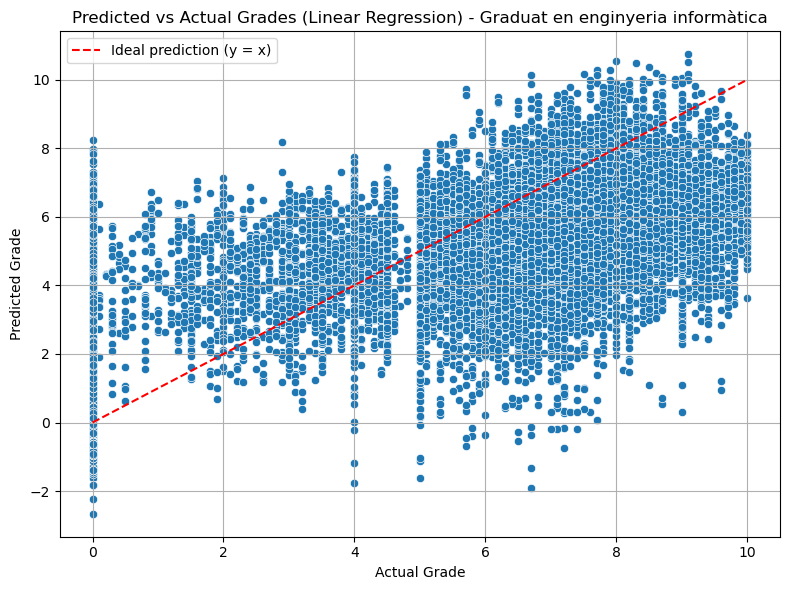

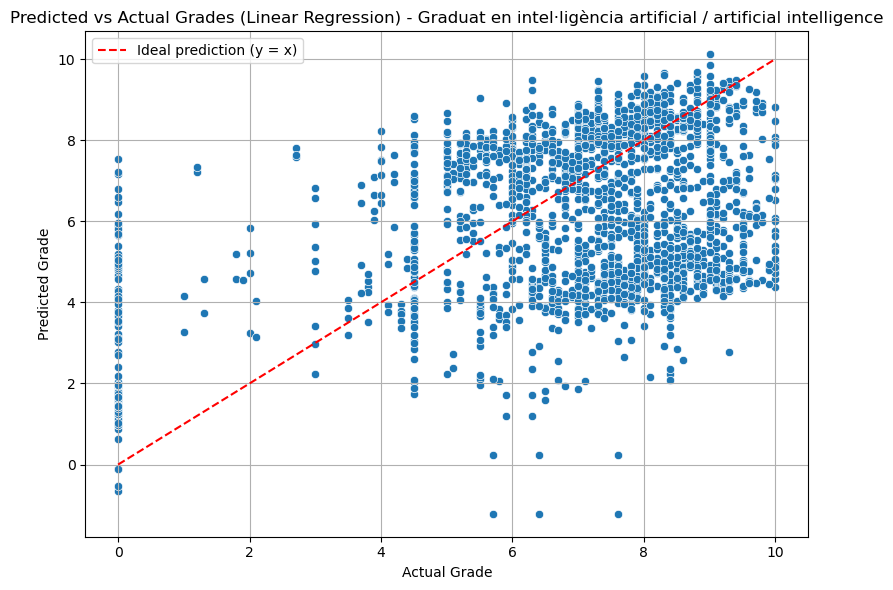

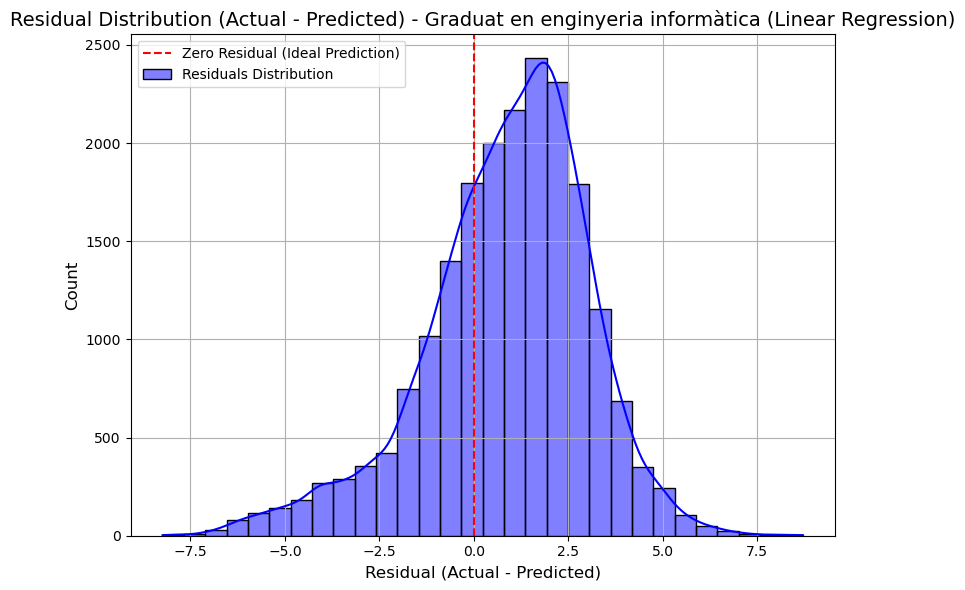

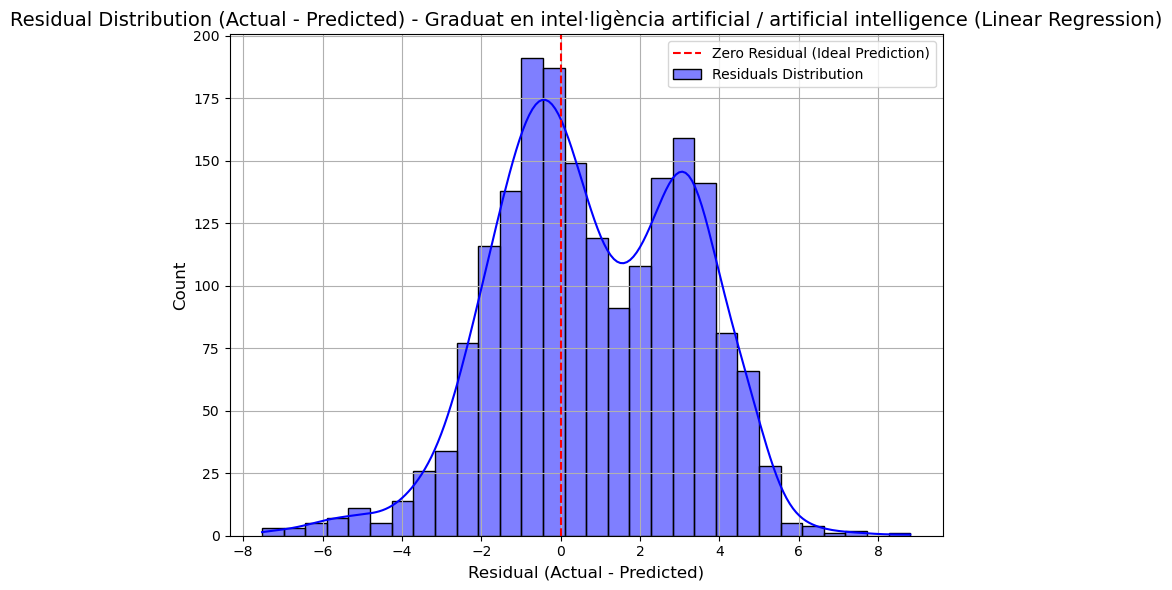

In [ ]:
# Ploting Linear Regression predictions
plot_predicted_vs_actual(df_pred_target, 'predicted_nota_assignatura_lr', 'Linear Regression', unique_studies)
plot_residuals(df_pred_target, 'predicted_nota_assignatura_lr', 'Linear Regression', unique_studies)
plot_barplot_avg_grades(df_pred_target, 'predicted_nota_assignatura_lr', 'Linear Regression', unique_studies)


## Polynomial Regression

In [43]:
from sklearn.preprocessing import PolynomialFeatures
poly_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('regressor', LinearRegression())
])

# Train the polynomial regression model
poly_model.fit(X_train, y_train)

# Evaluate R-squared on training data
print("Polynomial Regression - Model R-squared on train data:", poly_model.score(X_train, y_train))

# Make predictions for 2023/24 data
df_pred_target['predicted_nota_assignatura_poly'] = poly_model.predict(X_pred)

# Make predictions for 2023/24 data
df_pred_target['predicted_nota_assignatura_poly'] = poly_model.predict(X_pred)


Polynomial Regression - Model R-squared on train data: 0.4221346528118375


In [44]:
# Evaluating Polynomial Regression
evaluate_model(
    model_name='Polynomial Regression', 
    model=poly_model, 
    X_pred=X_pred, 
    y_pred=y_pred, 
    df_pred_target=df_pred_target, 
    prediction_column='predicted_nota_assignatura_poly'
)

Polynomial Regression - R² Score on 2023/24 prediction set: 0.19
Polynomial Regression - Mean Absolute Error (MAE): 1.92
Polynomial Regression - Mean Squared Error for 2023/24 predictions: 5.52
Polynomial Regression - Root Mean Squared Error (RMSE): 2.35


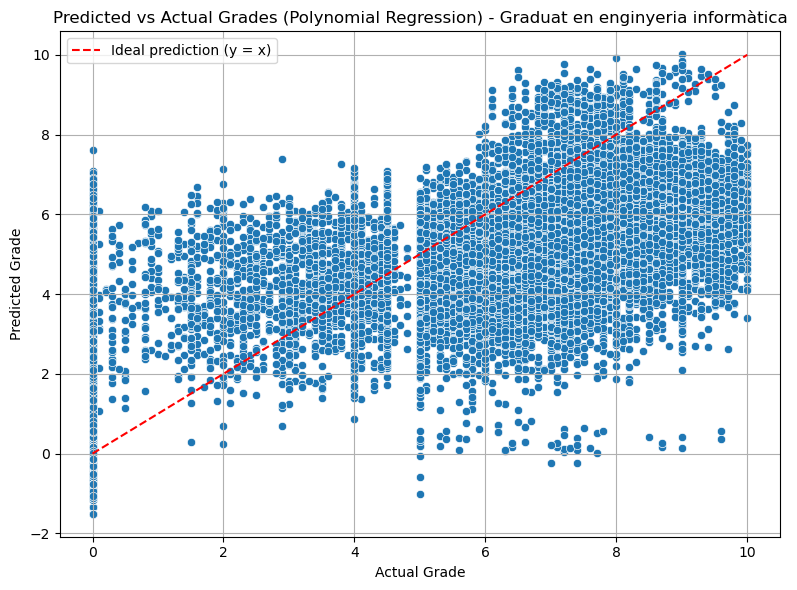

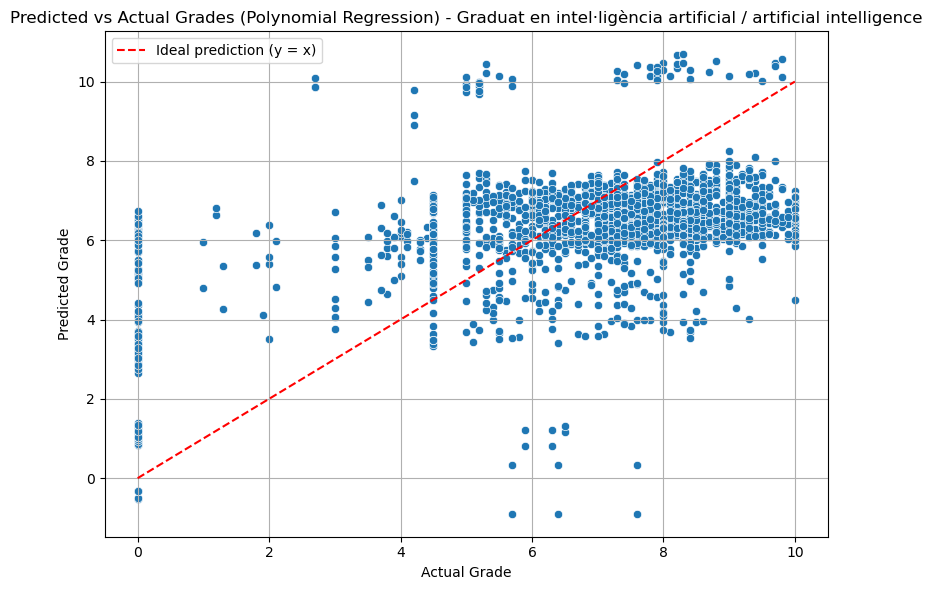

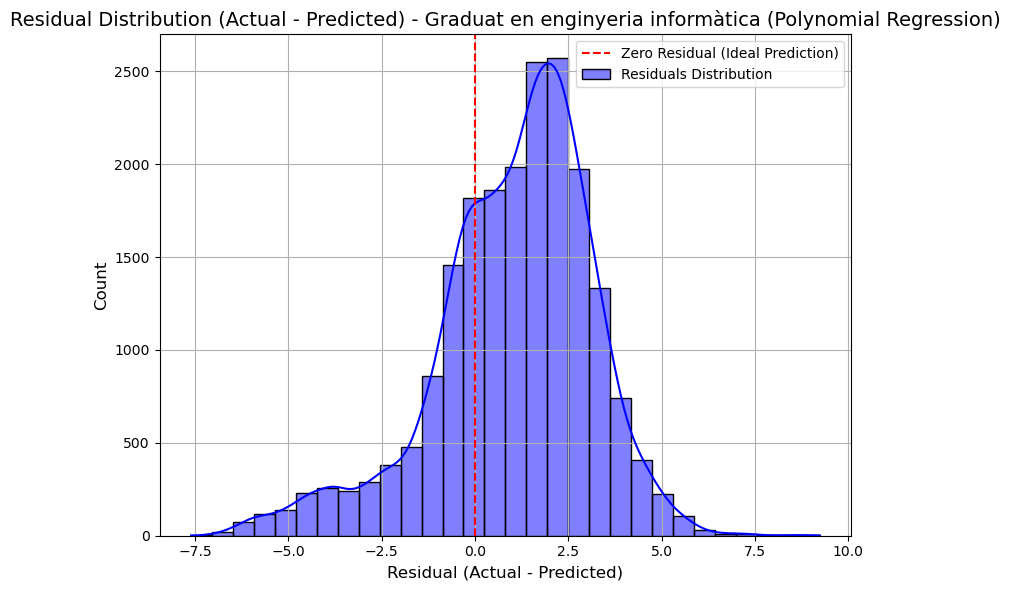

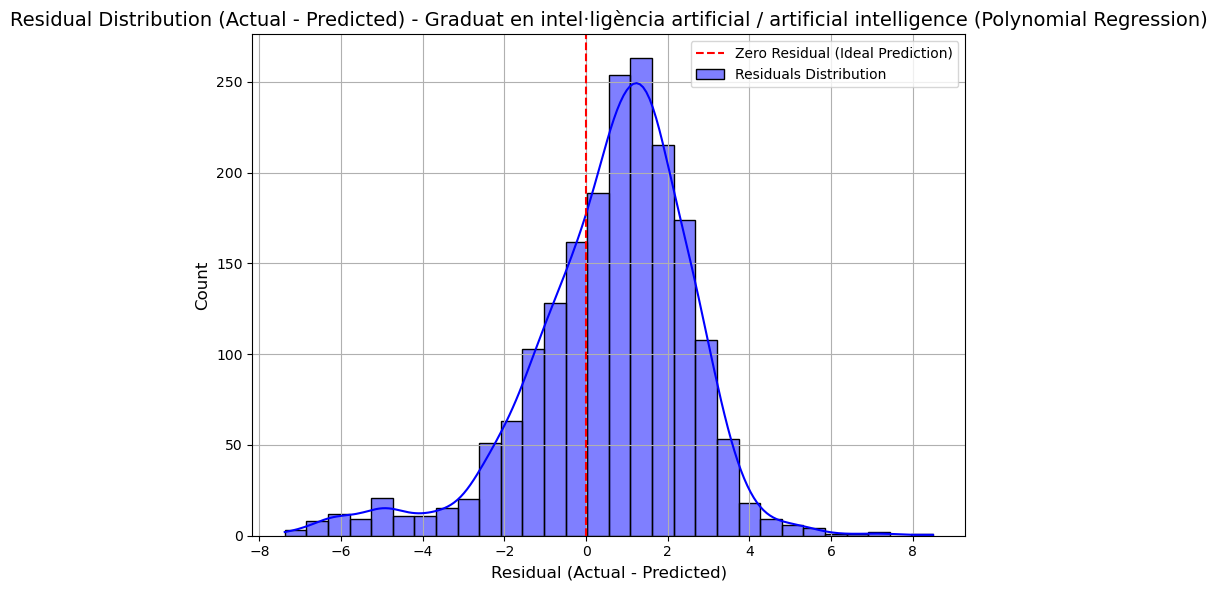

In [ ]:
#Plotting Polynomial Regression predictions
plot_predicted_vs_actual(df_pred_target, 'predicted_nota_assignatura_poly', 'Polynomial Regression', unique_studies)
plot_residuals(df_pred_target, 'predicted_nota_assignatura_poly', 'Polynomial Regression', unique_studies)
plot_barplot_avg_grades(df_pred_target, 'predicted_nota_assignatura_poly', 'Polynomial Regression', unique_studies)


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
# Random Forest Model
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train the Random Forest model
rf_model.fit(X_train, y_train)

# Evaluate R-squared on training data
print("Random Forest - Model R-squared on train data:", rf_model.score(X_train, y_train))

# Make predictions for 2023/24 data
df_pred_target['predicted_nota_assignatura_rf'] = rf_model.predict(X_pred)


In [ ]:
# Evaluating Random Forest
evaluate_model(
    model_name='Random Forest', 
    model=rf_model, 
    X_pred=X_pred, 
    y_pred=y_pred, 
    df_pred_target=df_pred_target, 
    prediction_column='predicted_nota_assignatura_rf'
)

In [ ]:
# Plotting Random Forest predictions
plot_predicted_vs_actual(df_pred_target, 'predicted_nota_assignatura_rf', 'Random Forest', unique_studies)
plot_residuals(df_pred_target, 'predicted_nota_assignatura_rf', 'Random Forest', unique_studies)
plot_barplot_avg_grades(df_pred_target, 'predicted_nota_assignatura_rf', 'Random Forest', unique_studies)

----------------------------------


DECIDE WHICH ONE IS BETTER